
 # Protein Thermophilicity Prediction
by Daniel Huertas, Jona Rott, Paulina Luquin, Xiaomeng Xu 

##  Problem Formulation
Thermostable proteins are able to withstand higher temperatures keeping their structure thus can be used for enzyme engineering to potentially accelerate chemical reactions.

In this work we want to implement different machine learning models to build a predictive model to identify thermophilic and non-thermophilic proteins.

## Working files:

1. The dataset found in "protein data.csv" contains over 4,500 proteins (samples) and around 1,000 physicochemical and structural measurements calculated from the protein sequence (features). The first row is a header containing the names of all descriptors, these are shown in the table 1 from the file named "ExamProject.pdf".
2. The data found in "thermophilicity labels.csv" contains the labels for the proteins. The first column is the ID of the protein and the second column is the label (1 for thermophilic, 0 for non-thermophilic).
3. The dataset to evaluate the predictions of the model by submitting the predictions to the AI leaderboard (true labels are hidden) is in the file "unknown protein data.csv", the file has the same data format as the original "protein data.csv".
4. The demo file "random predictions.csv" has the data format for the leaderboard submission: no header, the first column is the protein id and the second column is the prediction, with comma seperated columns.

## Contents:
The structure of the project is shown below in the contents of this file, here you can find the stages that were followed in order to build the classification model.
0. Library Importation & Settings 

1. Data Preparation: Importing & Matching Data 

2. Data Pre-Processing: Apply pre-processing steps to the training and testing datasets separately in order to avoid data leakage.

3. Modeling:

    A) **K - Nearest Neighbors**:  

    B) **Logistic Regression & Elastic Net Regularization**:   

    C) **Support Vector Machines**:   
    
4. Model Selection: 

## 1.  Library Importation & Settings
To begin with all the necessary packages to run every model are imported.


In [1]:
# Make the output visible
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
# Import the necessary data handling libraries 
import pylab as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Import the necessary machine learning libraries 
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import make_scorer, matthews_corrcoef
# Import other necessary libraries
from collections import Counter
import time

## 2.  Data Preparation 

The second section of the project is focused in importing and transforming the Data into the proper format to be able to process it. To build an initial understanding of the dataset, it is checked that the importation process was correctly implemented by printing the first few lines of the newly created dataframes.

### Importing:

In [2]:
# Import the data, separating the features and labels and the unseen data 
x = pd.read_csv('protein_data.csv')
y = pd.read_csv('thermophilicity_labels.csv')
x_new = pd.read_csv('unknown_protein_data.csv')
x.head()

,protein_id,AA_A,AA_C,AA_D,AA_E,AA_F,AA_G,AA_H,AA_I,AA_K,...,CTDd_solv_g3r100,molW,Ch_t,Ch_p,Ch_n,pol,nonp,arom,hydro,vdWV
0,p_ZUS6,0.126923,0.000000,0.046154,0.073077,0.025000,0.098077,0.025000,0.034615,0.067308,...,100.000000,54646.1,8.0,70.0,62.0,250.0,270.0,23.0,5.455000,NaN
1,p_9BCZ,0.078534,0.005236,0.026178,0.136126,0.047120,0.120419,0.026178,0.036649,0.052356,...,96.335079,21214.5,1.0,32.0,31.0,82.0,NaN,NaN,7.102094,3.369738
2,p_H8I0,NaN,NaN,0.073836,0.036918,0.043339,NaN,0.025682,0.025682,0.064205,...,99.839486,68138.0,13.0,82.0,69.0,297.0,326.0,72.0,5.020385,3.216356
3,p_M5WZ,NaN,0.007143,0.069048,0.064286,0.040476,0.100000,0.016667,0.057143,0.071429,...,98.571429,46409.3,2.0,58.0,56.0,NaN,221.0,35.0,6.116190,3.314286
4,p_RP34,NaN,0.009639,0.038554,0.077108,0.026506,0.081928,0.014458,0.098795,0.079518,...,98.072289,NaN,9.0,57.0,NaN,193.0,222.0,26.0,5.055663,3.333422


In [3]:
# Print the first 5 lines of the labels
y.head()

,protein_id,label
0,p_N1RZ,0
1,p_PT9D,0
2,p_MD00,0
3,p_Y0MU,0
4,p_GSL8,1


### Matching:
The samples are sorted to match features and labels. 

In [4]:
# Check if columns are the same (excluding the first column, the ID)
same_columns = (x.columns[1:] == x_new.columns[1:]).all()
print("The columns in the new data and original data match: ", same_columns)

# Convert to numpy arrays
x = np.array(x)
y = np.array(y)
x_new = np.array(x_new)

# Array with protein_ids only for matching
x_id = x[:, 0]
y_id = y[:, 0]

# Matching the data
truth_table = (x_id[:, np.newaxis] == y_id)
ind = np.where(truth_table == True)
x = x[ind[0], :]
y = y[ind[1], :]

# Removing the first column with protein_ids, but save them for the new (unknown) proteins
x_new_id = x_new[:, 0]
x = x[:, 1:]
y = y[:, 1:]
x_new = x_new[:, 1:]

# Reshape y to a 1D array
y = np.squeeze(y)
# Convert y to integers
y = y.astype(int)


The columns in the new data and original data match:  True


## 3. Data Pre-Processing: 

Now that the data is ready to be explored, it is necessary to find out how many missing values are present, to understand if it is useful to drop samples/features or if it is better to impute the missing values. In this case it was decided to delete no features and keep all possible predictive information.

In [5]:
#find the number of missing values
missing = pd.isna(x).sum()
print("There are %d missing values" % missing)
#calculate the proportion of missing values to the total number of values
missing_values = missing / x.size
print(" %.1f%% of the data are missing values" % (missing_values*100))
#find the features that have more than 10%
for i in range(x.shape[1]):
    empty = pd.isna(x[:,i]).sum()
    fraction = empty / x[:,i].size
    if fraction >= 0.10:
        print("Feature %d has %.1f%% missing values" % (i,fraction*100))
        

There are 239786 missing values
 5.0% of the data are missing values
Feature 0 has 10.2% missing values
Feature 10 has 10.0% missing values
Feature 11 has 10.1% missing values
Feature 30 has 10.1% missing values
Feature 38 has 10.1% missing values
Feature 42 has 10.1% missing values
Feature 75 has 10.1% missing values
Feature 100 has 10.1% missing values
Feature 103 has 10.2% missing values
Feature 118 has 10.1% missing values
Feature 122 has 10.1% missing values
Feature 124 has 10.1% missing values
Feature 192 has 10.1% missing values
Feature 209 has 10.2% missing values
Feature 260 has 10.0% missing values
Feature 279 has 10.0% missing values
Feature 285 has 10.0% missing values
Feature 291 has 10.1% missing values
Feature 299 has 10.2% missing values
Feature 355 has 10.2% missing values
Feature 367 has 10.1% missing values
Feature 381 has 10.0% missing values
Feature 383 has 10.2% missing values
Feature 392 has 10.2% missing values
Feature 398 has 10.1% missing values
Feature 399 ha

The imputing, scaling and dimensionality reduction methods are applied below.

PCA(n_components=0.9)

638 PCs account for 90.02 % of the total variance!


<BarContainer object of 638 artists>

Text(0, 0.5, 'Explained variance ratio')

Text(0.5, 0, 'Principal component index')

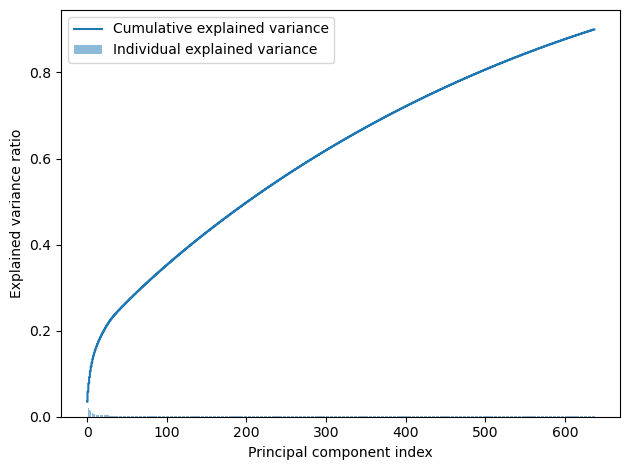

In [6]:
# Impute and standardize full dataset
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler = StandardScaler()

x_imputed = imputer_mean.fit_transform(x)
x_sk_imp = scaler.fit_transform(x_imputed)

# Imputation and standardization for unknown data based on x
x_new_imputed = imputer_mean.transform(x_new)
x_new_sk_imp = scaler.transform(x_new_imputed)

# PCA for the full dataset and unknown data
pca = PCA(n_components=0.9)
pca.fit(x_sk_imp)
x_sk_imp_pca=pca.transform(x_sk_imp)
x_new_sk_imp_pca=pca.transform(x_new_sk_imp)

expl_var = pca.n_components_
exp_var_pca = pca.explained_variance_ratio_
total_variance_ratio = sum(exp_var_pca)
print("%.d PCs account for %.2f %% of the total variance!"%(expl_var,total_variance_ratio*100))

# Cumulative sum of eigenvalues that will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot of the cumulative variance
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


## 3. Modeling:
To prevent inbalances in the train- test split of the data, for each model K-Fold cross validation is implemented, K was chosen depending on the computational complexity of each model. The models were imputed using the mean values and then normalized with the scaler function. Additionally, Principal Component Analysis (PCA) is employed to effectively reduce the dimensionality of our dataset, thereby extracting and emphasizing the most relevant features.

Tuning is done within the gridsearch method with the MCC metric for scoring. The preprocessing is done within each fold to prevent data-leakage. The optimal hyperparameters are determined with a grid-search. 

Then the predictions on test data are performed once per fold and the metrics are calculated accordingly. 

Finally, using the most common parameters identified during the grid-search, a final model is fit on the whole dataset to predict the thermophilicity of proteins in a unseen dataset. 

### A) **K - Nearest Neighbors**:  

In [7]:
# Clock the runtime of the code
start_time_KNN = time.time()

kf=StratifiedKFold(n_splits=5)

best_acc_val_knn=[]
best_acc_test_knn=[]
best_precision_test_knn=[]
best_recall_test_knn=[]
best_mcc_test_knn=[]
best_auc_test_knn=[]
best_neighbors_knn=[]


counter=0

for train_index, test_index in kf.split(x,y):
    X_train_knn=x[train_index]
    X_test_knn=x[test_index]
    y_train_knn=y[train_index]
    y_test_knn=y[test_index]
    
    # Imputing and Scaling for each interation
    
    # Imputing
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train_knn_im = imputer.fit_transform(X_train_knn)
    X_test_knn_im = imputer.transform(X_test_knn)
    
    # Scaling
    scaler = StandardScaler()
    X_train_knn_sc = scaler.fit_transform(X_train_knn_im)
    X_test_knn_sc = scaler.transform(X_test_knn_im)
        
    
    # PCA    
    pca = PCA(n_components=expl_var)
    pca.fit(X_train_knn_sc)
    Xr_train_knn=pca.transform(X_train_knn_sc)
    Xr_test_knn=pca.transform(X_test_knn_sc)

    explained_variance_ratio = pca.explained_variance_ratio_
    total_variance_ratio = sum(explained_variance_ratio)


    X_subtrain_knn,X_val_knn,y_subtrain_knn,y_val_knn=train_test_split(Xr_train_knn,y_train_knn,test_size=0.2,random_state=42)

    neighbors=np.arange(1,51)
    accuracy_val_knn=[]

    for k in neighbors:
        knn=KNeighborsClassifier(n_neighbors=k,algorithm="brute",metric="minkowski",p=2)
        knn.fit(X_subtrain_knn,y_subtrain_knn) 
        predictions_val_knn=knn.predict(X_val_knn)

        acc_val_knn=metrics.accuracy_score(y_val_knn,predictions_val_knn)
        accuracy_val_knn.append(acc_val_knn)

    best_k_knn=neighbors[np.argmax(accuracy_val_knn)]

    # Refit the model using the full training (subtraining+validation) using the best k value
    knn=KNeighborsClassifier(n_neighbors=best_k_knn,algorithm="brute",metric="minkowski",p=2)
    knn.fit(Xr_train_knn,y_train_knn)
    predictions_test_knn=knn.predict(Xr_test_knn)
    test_accuracy_knn=metrics.accuracy_score(y_test_knn,predictions_test_knn)

    best_acc_test_knn.append(test_accuracy_knn)
    best_precision_test_knn.append(metrics.precision_score(y_test_knn,predictions_test_knn))
    best_recall_test_knn.append(metrics.recall_score(y_test_knn,predictions_test_knn))
    best_mcc_test_knn.append(metrics.matthews_corrcoef(y_test_knn,predictions_test_knn))
    best_auc_test_knn.append(metrics.roc_auc_score(y_test_knn,predictions_test_knn))
    best_neighbors_knn.append(best_k_knn)
    best_acc_val_knn.append(np.max(accuracy_val_knn))
    counter+=1
    
# Convert python list into numpy array
best_neighbors_knn=np.array(best_neighbors_knn)
best_acc_test_knn=np.array(best_acc_test_knn)
best_precision_test_knn=np.array(best_precision_test_knn)
best_recall_test_knn=np.array(best_recall_test_knn)
best_mcc_test_knn=np.array(best_mcc_test_knn)
best_auc_test_knn=np.array(best_auc_test_knn)
best_acc_val_knn=np.array(best_acc_val_knn)

print("Average k: %.2f (+- %.2f)" % (best_neighbors_knn.mean(), best_neighbors_knn.std()) )
print("Accuracy (Val): %.2f (+- %.2f)" % (best_acc_val_knn.mean(), best_acc_val_knn.std()) )
print("Accuracy (Test): %.2f (+- %.2f)" % (best_acc_test_knn.mean(), best_acc_test_knn.std()) )
print("Average Precision (Test): %.2f (+- %.2f)" % (best_precision_test_knn.mean(),best_precision_test_knn.std()))
print("Average Recall (Test): %.2f (+- %.2f)" % (best_recall_test_knn.mean(),best_recall_test_knn.std()))
print("Average MCC (Test): %.2f (+- %.2f)" % (best_mcc_test_knn.mean(),best_mcc_test_knn.std()))
print("Average ROC-AUC (Test): %.2f (+- %.2f)" % (best_auc_test_knn.mean(),best_auc_test_knn.std()))

# Prediction on the unknown dataset
knn=KNeighborsClassifier(n_neighbors=int(best_neighbors_knn.mean()),algorithm="brute",metric="minkowski",p=2)
knn.fit(x_sk_imp_pca,y)
predictions_un=knn.predict(x_new_sk_imp_pca)


# Save predictions with imputation to a CSV file
df_imputed = pd.DataFrame({
    'protein_id': x_new_id,
    'prediction': predictions_un
})
df_imputed.to_csv('best_KNearestNeighbor_SVDPCA_final.csv', index=False, header=False)

# Calculate runtime
end_time_KNN = time.time()
runtime_KNN = end_time_KNN - start_time_KNN
print("Runtime:\t\t%.2f seconds" % runtime_KNN)

PCA(n_components=638)

KNeighborsClassifier(algorithm='brute', n_neighbors=1)

KNeighborsClassifier(algorithm='brute', n_neighbors=2)

KNeighborsClassifier(algorithm='brute', n_neighbors=3)

KNeighborsClassifier(algorithm='brute', n_neighbors=4)

KNeighborsClassifier(algorithm='brute')

KNeighborsClassifier(algorithm='brute', n_neighbors=6)

KNeighborsClassifier(algorithm='brute', n_neighbors=7)

KNeighborsClassifier(algorithm='brute', n_neighbors=8)

KNeighborsClassifier(algorithm='brute', n_neighbors=9)

KNeighborsClassifier(algorithm='brute', n_neighbors=10)

KNeighborsClassifier(algorithm='brute', n_neighbors=11)

KNeighborsClassifier(algorithm='brute', n_neighbors=12)

KNeighborsClassifier(algorithm='brute', n_neighbors=13)

KNeighborsClassifier(algorithm='brute', n_neighbors=14)

KNeighborsClassifier(algorithm='brute', n_neighbors=15)

KNeighborsClassifier(algorithm='brute', n_neighbors=16)

KNeighborsClassifier(algorithm='brute', n_neighbors=17)

KNeighborsClassifier(algorithm='brute', n_neighbors=18)

KNeighborsClassifier(algorithm='brute', n_neighbors=19)

KNeighborsClassifier(algorithm='brute', n_neighbors=20)

KNeighborsClassifier(algorithm='brute', n_neighbors=21)

KNeighborsClassifier(algorithm='brute', n_neighbors=22)

KNeighborsClassifier(algorithm='brute', n_neighbors=23)

KNeighborsClassifier(algorithm='brute', n_neighbors=24)

KNeighborsClassifier(algorithm='brute', n_neighbors=25)

KNeighborsClassifier(algorithm='brute', n_neighbors=26)

KNeighborsClassifier(algorithm='brute', n_neighbors=27)

KNeighborsClassifier(algorithm='brute', n_neighbors=28)

KNeighborsClassifier(algorithm='brute', n_neighbors=29)

KNeighborsClassifier(algorithm='brute', n_neighbors=30)

KNeighborsClassifier(algorithm='brute', n_neighbors=31)

KNeighborsClassifier(algorithm='brute', n_neighbors=32)

KNeighborsClassifier(algorithm='brute', n_neighbors=33)

KNeighborsClassifier(algorithm='brute', n_neighbors=34)

KNeighborsClassifier(algorithm='brute', n_neighbors=35)

KNeighborsClassifier(algorithm='brute', n_neighbors=36)

KNeighborsClassifier(algorithm='brute', n_neighbors=37)

KNeighborsClassifier(algorithm='brute', n_neighbors=38)

KNeighborsClassifier(algorithm='brute', n_neighbors=39)

KNeighborsClassifier(algorithm='brute', n_neighbors=40)

KNeighborsClassifier(algorithm='brute', n_neighbors=41)

KNeighborsClassifier(algorithm='brute', n_neighbors=42)

KNeighborsClassifier(algorithm='brute', n_neighbors=43)

KNeighborsClassifier(algorithm='brute', n_neighbors=44)

KNeighborsClassifier(algorithm='brute', n_neighbors=45)

KNeighborsClassifier(algorithm='brute', n_neighbors=46)

KNeighborsClassifier(algorithm='brute', n_neighbors=47)

KNeighborsClassifier(algorithm='brute', n_neighbors=48)

KNeighborsClassifier(algorithm='brute', n_neighbors=49)

KNeighborsClassifier(algorithm='brute', n_neighbors=50)

KNeighborsClassifier(algorithm='brute', n_neighbors=41)

PCA(n_components=638)

KNeighborsClassifier(algorithm='brute', n_neighbors=1)

KNeighborsClassifier(algorithm='brute', n_neighbors=2)

KNeighborsClassifier(algorithm='brute', n_neighbors=3)

KNeighborsClassifier(algorithm='brute', n_neighbors=4)

KNeighborsClassifier(algorithm='brute')

KNeighborsClassifier(algorithm='brute', n_neighbors=6)

KNeighborsClassifier(algorithm='brute', n_neighbors=7)

KNeighborsClassifier(algorithm='brute', n_neighbors=8)

KNeighborsClassifier(algorithm='brute', n_neighbors=9)

KNeighborsClassifier(algorithm='brute', n_neighbors=10)

KNeighborsClassifier(algorithm='brute', n_neighbors=11)

KNeighborsClassifier(algorithm='brute', n_neighbors=12)

KNeighborsClassifier(algorithm='brute', n_neighbors=13)

KNeighborsClassifier(algorithm='brute', n_neighbors=14)

KNeighborsClassifier(algorithm='brute', n_neighbors=15)

KNeighborsClassifier(algorithm='brute', n_neighbors=16)

KNeighborsClassifier(algorithm='brute', n_neighbors=17)

KNeighborsClassifier(algorithm='brute', n_neighbors=18)

KNeighborsClassifier(algorithm='brute', n_neighbors=19)

KNeighborsClassifier(algorithm='brute', n_neighbors=20)

KNeighborsClassifier(algorithm='brute', n_neighbors=21)

KNeighborsClassifier(algorithm='brute', n_neighbors=22)

KNeighborsClassifier(algorithm='brute', n_neighbors=23)

KNeighborsClassifier(algorithm='brute', n_neighbors=24)

KNeighborsClassifier(algorithm='brute', n_neighbors=25)

KNeighborsClassifier(algorithm='brute', n_neighbors=26)

KNeighborsClassifier(algorithm='brute', n_neighbors=27)

KNeighborsClassifier(algorithm='brute', n_neighbors=28)

KNeighborsClassifier(algorithm='brute', n_neighbors=29)

KNeighborsClassifier(algorithm='brute', n_neighbors=30)

KNeighborsClassifier(algorithm='brute', n_neighbors=31)

KNeighborsClassifier(algorithm='brute', n_neighbors=32)

KNeighborsClassifier(algorithm='brute', n_neighbors=33)

KNeighborsClassifier(algorithm='brute', n_neighbors=34)

KNeighborsClassifier(algorithm='brute', n_neighbors=35)

KNeighborsClassifier(algorithm='brute', n_neighbors=36)

KNeighborsClassifier(algorithm='brute', n_neighbors=37)

KNeighborsClassifier(algorithm='brute', n_neighbors=38)

KNeighborsClassifier(algorithm='brute', n_neighbors=39)

KNeighborsClassifier(algorithm='brute', n_neighbors=40)

KNeighborsClassifier(algorithm='brute', n_neighbors=41)

KNeighborsClassifier(algorithm='brute', n_neighbors=42)

KNeighborsClassifier(algorithm='brute', n_neighbors=43)

KNeighborsClassifier(algorithm='brute', n_neighbors=44)

KNeighborsClassifier(algorithm='brute', n_neighbors=45)

KNeighborsClassifier(algorithm='brute', n_neighbors=46)

KNeighborsClassifier(algorithm='brute', n_neighbors=47)

KNeighborsClassifier(algorithm='brute', n_neighbors=48)

KNeighborsClassifier(algorithm='brute', n_neighbors=49)

KNeighborsClassifier(algorithm='brute', n_neighbors=50)

KNeighborsClassifier(algorithm='brute', n_neighbors=36)

PCA(n_components=638)

KNeighborsClassifier(algorithm='brute', n_neighbors=1)

KNeighborsClassifier(algorithm='brute', n_neighbors=2)

KNeighborsClassifier(algorithm='brute', n_neighbors=3)

KNeighborsClassifier(algorithm='brute', n_neighbors=4)

KNeighborsClassifier(algorithm='brute')

KNeighborsClassifier(algorithm='brute', n_neighbors=6)

KNeighborsClassifier(algorithm='brute', n_neighbors=7)

KNeighborsClassifier(algorithm='brute', n_neighbors=8)

KNeighborsClassifier(algorithm='brute', n_neighbors=9)

KNeighborsClassifier(algorithm='brute', n_neighbors=10)

KNeighborsClassifier(algorithm='brute', n_neighbors=11)

KNeighborsClassifier(algorithm='brute', n_neighbors=12)

KNeighborsClassifier(algorithm='brute', n_neighbors=13)

KNeighborsClassifier(algorithm='brute', n_neighbors=14)

KNeighborsClassifier(algorithm='brute', n_neighbors=15)

KNeighborsClassifier(algorithm='brute', n_neighbors=16)

KNeighborsClassifier(algorithm='brute', n_neighbors=17)

KNeighborsClassifier(algorithm='brute', n_neighbors=18)

KNeighborsClassifier(algorithm='brute', n_neighbors=19)

KNeighborsClassifier(algorithm='brute', n_neighbors=20)

KNeighborsClassifier(algorithm='brute', n_neighbors=21)

KNeighborsClassifier(algorithm='brute', n_neighbors=22)

KNeighborsClassifier(algorithm='brute', n_neighbors=23)

KNeighborsClassifier(algorithm='brute', n_neighbors=24)

KNeighborsClassifier(algorithm='brute', n_neighbors=25)

KNeighborsClassifier(algorithm='brute', n_neighbors=26)

KNeighborsClassifier(algorithm='brute', n_neighbors=27)

KNeighborsClassifier(algorithm='brute', n_neighbors=28)

KNeighborsClassifier(algorithm='brute', n_neighbors=29)

KNeighborsClassifier(algorithm='brute', n_neighbors=30)

KNeighborsClassifier(algorithm='brute', n_neighbors=31)

KNeighborsClassifier(algorithm='brute', n_neighbors=32)

KNeighborsClassifier(algorithm='brute', n_neighbors=33)

KNeighborsClassifier(algorithm='brute', n_neighbors=34)

KNeighborsClassifier(algorithm='brute', n_neighbors=35)

KNeighborsClassifier(algorithm='brute', n_neighbors=36)

KNeighborsClassifier(algorithm='brute', n_neighbors=37)

KNeighborsClassifier(algorithm='brute', n_neighbors=38)

KNeighborsClassifier(algorithm='brute', n_neighbors=39)

KNeighborsClassifier(algorithm='brute', n_neighbors=40)

KNeighborsClassifier(algorithm='brute', n_neighbors=41)

KNeighborsClassifier(algorithm='brute', n_neighbors=42)

KNeighborsClassifier(algorithm='brute', n_neighbors=43)

KNeighborsClassifier(algorithm='brute', n_neighbors=44)

KNeighborsClassifier(algorithm='brute', n_neighbors=45)

KNeighborsClassifier(algorithm='brute', n_neighbors=46)

KNeighborsClassifier(algorithm='brute', n_neighbors=47)

KNeighborsClassifier(algorithm='brute', n_neighbors=48)

KNeighborsClassifier(algorithm='brute', n_neighbors=49)

KNeighborsClassifier(algorithm='brute', n_neighbors=50)

KNeighborsClassifier(algorithm='brute', n_neighbors=40)

PCA(n_components=638)

KNeighborsClassifier(algorithm='brute', n_neighbors=1)

KNeighborsClassifier(algorithm='brute', n_neighbors=2)

KNeighborsClassifier(algorithm='brute', n_neighbors=3)

KNeighborsClassifier(algorithm='brute', n_neighbors=4)

KNeighborsClassifier(algorithm='brute')

KNeighborsClassifier(algorithm='brute', n_neighbors=6)

KNeighborsClassifier(algorithm='brute', n_neighbors=7)

KNeighborsClassifier(algorithm='brute', n_neighbors=8)

KNeighborsClassifier(algorithm='brute', n_neighbors=9)

KNeighborsClassifier(algorithm='brute', n_neighbors=10)

KNeighborsClassifier(algorithm='brute', n_neighbors=11)

KNeighborsClassifier(algorithm='brute', n_neighbors=12)

KNeighborsClassifier(algorithm='brute', n_neighbors=13)

KNeighborsClassifier(algorithm='brute', n_neighbors=14)

KNeighborsClassifier(algorithm='brute', n_neighbors=15)

KNeighborsClassifier(algorithm='brute', n_neighbors=16)

KNeighborsClassifier(algorithm='brute', n_neighbors=17)

KNeighborsClassifier(algorithm='brute', n_neighbors=18)

KNeighborsClassifier(algorithm='brute', n_neighbors=19)

KNeighborsClassifier(algorithm='brute', n_neighbors=20)

KNeighborsClassifier(algorithm='brute', n_neighbors=21)

KNeighborsClassifier(algorithm='brute', n_neighbors=22)

KNeighborsClassifier(algorithm='brute', n_neighbors=23)

KNeighborsClassifier(algorithm='brute', n_neighbors=24)

KNeighborsClassifier(algorithm='brute', n_neighbors=25)

KNeighborsClassifier(algorithm='brute', n_neighbors=26)

KNeighborsClassifier(algorithm='brute', n_neighbors=27)

KNeighborsClassifier(algorithm='brute', n_neighbors=28)

KNeighborsClassifier(algorithm='brute', n_neighbors=29)

KNeighborsClassifier(algorithm='brute', n_neighbors=30)

KNeighborsClassifier(algorithm='brute', n_neighbors=31)

KNeighborsClassifier(algorithm='brute', n_neighbors=32)

KNeighborsClassifier(algorithm='brute', n_neighbors=33)

KNeighborsClassifier(algorithm='brute', n_neighbors=34)

KNeighborsClassifier(algorithm='brute', n_neighbors=35)

KNeighborsClassifier(algorithm='brute', n_neighbors=36)

KNeighborsClassifier(algorithm='brute', n_neighbors=37)

KNeighborsClassifier(algorithm='brute', n_neighbors=38)

KNeighborsClassifier(algorithm='brute', n_neighbors=39)

KNeighborsClassifier(algorithm='brute', n_neighbors=40)

KNeighborsClassifier(algorithm='brute', n_neighbors=41)

KNeighborsClassifier(algorithm='brute', n_neighbors=42)

KNeighborsClassifier(algorithm='brute', n_neighbors=43)

KNeighborsClassifier(algorithm='brute', n_neighbors=44)

KNeighborsClassifier(algorithm='brute', n_neighbors=45)

KNeighborsClassifier(algorithm='brute', n_neighbors=46)

KNeighborsClassifier(algorithm='brute', n_neighbors=47)

KNeighborsClassifier(algorithm='brute', n_neighbors=48)

KNeighborsClassifier(algorithm='brute', n_neighbors=49)

KNeighborsClassifier(algorithm='brute', n_neighbors=50)

KNeighborsClassifier(algorithm='brute', n_neighbors=32)

PCA(n_components=638)

KNeighborsClassifier(algorithm='brute', n_neighbors=1)

KNeighborsClassifier(algorithm='brute', n_neighbors=2)

KNeighborsClassifier(algorithm='brute', n_neighbors=3)

KNeighborsClassifier(algorithm='brute', n_neighbors=4)

KNeighborsClassifier(algorithm='brute')

KNeighborsClassifier(algorithm='brute', n_neighbors=6)

KNeighborsClassifier(algorithm='brute', n_neighbors=7)

KNeighborsClassifier(algorithm='brute', n_neighbors=8)

KNeighborsClassifier(algorithm='brute', n_neighbors=9)

KNeighborsClassifier(algorithm='brute', n_neighbors=10)

KNeighborsClassifier(algorithm='brute', n_neighbors=11)

KNeighborsClassifier(algorithm='brute', n_neighbors=12)

KNeighborsClassifier(algorithm='brute', n_neighbors=13)

KNeighborsClassifier(algorithm='brute', n_neighbors=14)

KNeighborsClassifier(algorithm='brute', n_neighbors=15)

KNeighborsClassifier(algorithm='brute', n_neighbors=16)

KNeighborsClassifier(algorithm='brute', n_neighbors=17)

KNeighborsClassifier(algorithm='brute', n_neighbors=18)

KNeighborsClassifier(algorithm='brute', n_neighbors=19)

KNeighborsClassifier(algorithm='brute', n_neighbors=20)

KNeighborsClassifier(algorithm='brute', n_neighbors=21)

KNeighborsClassifier(algorithm='brute', n_neighbors=22)

KNeighborsClassifier(algorithm='brute', n_neighbors=23)

KNeighborsClassifier(algorithm='brute', n_neighbors=24)

KNeighborsClassifier(algorithm='brute', n_neighbors=25)

KNeighborsClassifier(algorithm='brute', n_neighbors=26)

KNeighborsClassifier(algorithm='brute', n_neighbors=27)

KNeighborsClassifier(algorithm='brute', n_neighbors=28)

KNeighborsClassifier(algorithm='brute', n_neighbors=29)

KNeighborsClassifier(algorithm='brute', n_neighbors=30)

KNeighborsClassifier(algorithm='brute', n_neighbors=31)

KNeighborsClassifier(algorithm='brute', n_neighbors=32)

KNeighborsClassifier(algorithm='brute', n_neighbors=33)

KNeighborsClassifier(algorithm='brute', n_neighbors=34)

KNeighborsClassifier(algorithm='brute', n_neighbors=35)

KNeighborsClassifier(algorithm='brute', n_neighbors=36)

KNeighborsClassifier(algorithm='brute', n_neighbors=37)

KNeighborsClassifier(algorithm='brute', n_neighbors=38)

KNeighborsClassifier(algorithm='brute', n_neighbors=39)

KNeighborsClassifier(algorithm='brute', n_neighbors=40)

KNeighborsClassifier(algorithm='brute', n_neighbors=41)

KNeighborsClassifier(algorithm='brute', n_neighbors=42)

KNeighborsClassifier(algorithm='brute', n_neighbors=43)

KNeighborsClassifier(algorithm='brute', n_neighbors=44)

KNeighborsClassifier(algorithm='brute', n_neighbors=45)

KNeighborsClassifier(algorithm='brute', n_neighbors=46)

KNeighborsClassifier(algorithm='brute', n_neighbors=47)

KNeighborsClassifier(algorithm='brute', n_neighbors=48)

KNeighborsClassifier(algorithm='brute', n_neighbors=49)

KNeighborsClassifier(algorithm='brute', n_neighbors=50)

KNeighborsClassifier(algorithm='brute', n_neighbors=27)

Average k: 35.20 (+- 5.19)
Accuracy (Val): 0.88 (+- 0.01)
Accuracy (Test): 0.86 (+- 0.01)
Average Precision (Test): 0.81 (+- 0.02)
Average Recall (Test): 0.75 (+- 0.02)
Average MCC (Test): 0.68 (+- 0.02)
Average ROC-AUC (Test): 0.83 (+- 0.01)


KNeighborsClassifier(algorithm='brute', n_neighbors=35)

Runtime:		38.20 seconds


### B) **Logistic Regression & Elastic Net Regularization**:   

In [8]:
# Clock the runtime of the code
start_time_LOGREG = time.time()

l1_ratios=[0,0.25,0.5,0.75,1.0]
kf = StratifiedKFold(n_splits=5)

best_acc_test = []
auc_list = []
precision_list = []
recall_list = []
mcc_list = []
best_params = []

# Set the range of parameters for grid search
param_grid = {'C':np.logspace(-4,4,5),'l1_ratio':[0,0.25,0.5,0.75,1.0]}

for train_index, test_index in kf.split(x,y):
    x_train = x[train_index]
    x_test = x[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    # Imputing the missing points
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    x_train = imputer.fit_transform(x_train)
    x_test = imputer.transform(x_test)
    
    # Standardizing the data
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    # Apply PCA
    pca = PCA(n_components=expl_var)
    pca.fit(x_train)
    x_train=pca.transform(x_train)
    x_test=pca.transform(x_test)

    explained_variance_ratio = pca.explained_variance_ratio_
    total_variance_ratio = sum(explained_variance_ratio)
    
    # Define the model
    model = LogisticRegression(penalty='elasticnet',solver='saga',max_iter=4000)

    # Define the grid search
    mcc_scorer = make_scorer(matthews_corrcoef)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=mcc_scorer)
    grid_search.fit(x_train, y_train)
    
    # Append best params to the list
    best_params.append(grid_search.best_params_)
    
    # Predictions with the best model
    y_pred = grid_search.predict(x_test)
    
    # Calculate metrics
    acc = metrics.accuracy_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test,y_pred)
    precision = metrics.precision_score(y_test,y_pred, zero_division=1)
    recall = metrics.recall_score(y_test,y_pred)
    mcc = metrics.matthews_corrcoef(y_test,y_pred)
    
    # Store metrics in the lists
    best_acc_test.append(acc)
    auc_list.append(auc)
    precision_list.append(precision)
    recall_list.append(recall)
    mcc_list.append(mcc)
    
# Get most common params
most_common_params = Counter([str(param) for param in best_params]).most_common(1)[0][0]
most_common_params = eval(most_common_params)    
    
print("Average Accuracy (Test) = %.2f" % np.mean(best_acc_test))
print("Max Accuracy (Test) = %.2f" % np.max(best_acc_test))
print("Average AUC = %.2f" % np.mean(auc_list))
print("Max AUC = %.2f" % np.max(auc_list))
print("Average Precision = %.2f" % np.mean(precision_list))
print("Max Precision = %.2f" % np.max(precision_list))
print("Average Recall = %.2f" % np.mean(recall_list))
print("Max Recall = %.2f" % np.max(recall_list))
print("Average MCC = %.2f" % np.mean(mcc_list))
print("Max MCC = %.2f" % np.max(mcc_list))

# Prediction on the unknown dataset

# New model for predictions on the new data set
final_model = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=4000, C=most_common_params['C'], l1_ratio=most_common_params['l1_ratio'])
final_model.fit(x_sk_imp_pca, y)

# Predictions with final model
y_new_pred = final_model.predict(x_new_sk_imp_pca)

# Save predictions with imputation to a CSV file
df_imputed = pd.DataFrame({
    'protein_id': x_new_id,
    'prediction': y_new_pred
})
df_imputed.to_csv('LogReg_predictions_fulldatasetmodel_imputed_final.csv', index=False, header=False)


# Calculate runtime
end_time_LOGREG = time.time()
runtime_LOGREG = end_time_LOGREG - start_time_LOGREG
print("Runtime:\t\t%.2f seconds" % runtime_LOGREG)



PCA(n_components=638)

D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached 

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=4000, penalty='elasticnet',
                                          solver='saga'),
             param_grid={'C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1.0]},
             scoring=make_scorer(matthews_corrcoef))

PCA(n_components=638)

D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached 

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=4000, penalty='elasticnet',
                                          solver='saga'),
             param_grid={'C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1.0]},
             scoring=make_scorer(matthews_corrcoef))

PCA(n_components=638)

D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached 

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=4000, penalty='elasticnet',
                                          solver='saga'),
             param_grid={'C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1.0]},
             scoring=make_scorer(matthews_corrcoef))

PCA(n_components=638)

D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached 

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=4000, penalty='elasticnet',
                                          solver='saga'),
             param_grid={'C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1.0]},
             scoring=make_scorer(matthews_corrcoef))

PCA(n_components=638)

D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Study_Apps\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached 

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=4000, penalty='elasticnet',
                                          solver='saga'),
             param_grid={'C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1.0]},
             scoring=make_scorer(matthews_corrcoef))

Average Accuracy (Test) = 0.90
Max Accuracy (Test) = 0.91
Average AUC = 0.88
Max AUC = 0.89
Average Precision = 0.88
Max Precision = 0.91
Average Recall = 0.80
Max Recall = 0.82
Average MCC = 0.77
Max MCC = 0.79


LogisticRegression(C=0.01, l1_ratio=0.5, max_iter=4000, penalty='elasticnet',
                   solver='saga')

Runtime:		58588.40 seconds


### C) **Support Vector Machines**:   

In [9]:
# Clock the runtime of the code
start_time_SVM = time.time()

kf = StratifiedKFold(n_splits=5)
best_acc_test = []
auc_list = []
precision_list = []
recall_list = []
mcc_list = []

# RBF kernel
Cs = np.logspace(-4, 4, 10)
gammas = np.logspace(-4, 4, 10)
params = {"C": Cs, 'gamma': gammas}
best_params = []

for train_index, test_index in kf.split(x, y):
    x_train = x[train_index]
    x_test = x[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    # Imputing the missing points
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    x_train = imputer.fit_transform(x_train)
    x_test = imputer.transform(x_test)

    # Standardizing the data
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    # PCA    
    pca = PCA(n_components=expl_var)
    pca.fit(x_train)
    x_train=pca.transform(x_train)
    x_test=pca.transform(x_test)

    explained_variance_ratio = pca.explained_variance_ratio_
    total_variance_ratio = sum(explained_variance_ratio)
    
    model = SVC(kernel="rbf")
    mcc_scorer = make_scorer(matthews_corrcoef)
    gridsearch = GridSearchCV(model, params, cv=2, scoring=mcc_scorer)
    gridsearch.fit(x_train, y_train)
    
    # Append best params to the list
    best_params.append(gridsearch.best_params_)

    # Predictions with the best model
    y_pred = gridsearch.predict(x_test)

    # Calculate and append metrics
    acc = metrics.accuracy_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, zero_division=1)
    recall = metrics.recall_score(y_test, y_pred)
    mcc = metrics.matthews_corrcoef(y_test, y_pred)

    best_acc_test.append(acc)
    auc_list.append(auc)
    precision_list.append(precision)
    recall_list.append(recall)
    mcc_list.append(mcc)

    print("Optimal C=" + str(gridsearch.best_params_['C']) + ", Optimal gamma=" + str(gridsearch.best_params_['gamma']))
    

best_acc_test = np.array(best_acc_test)

print("Average Accuracy (Test) = %.2f (+- %.2f)" % (best_acc_test.mean(), best_acc_test.std()))
print("Average AUC = %.2f (+- %.2f)" % (np.mean(auc_list), np.std(auc_list)))
print("Average Precision = %.2f (+- %.2f)" % (np.mean(precision_list), np.std(precision_list)))
print("Average Recall = %.2f (+- %.2f)" % (np.mean(recall_list), np.std(recall_list)))
print("Average MCC = %.2f (+- %.2f)" % (np.mean(mcc_list), np.std(mcc_list)))

# Get most common params
most_common_params = Counter([str(param) for param in best_params]).most_common(1)[0][0]
most_common_params = eval(most_common_params)

# Predict on the unknown dataset

# New model for predications on the new data set
final_model = SVC(kernel="rbf", C=most_common_params['C'], gamma=most_common_params['gamma'])
final_model.fit(x_sk_imp_pca, y)

# Predictions with final model
y_new_pred = final_model.predict(x_new_sk_imp_pca)


# Save predictions with imputation to a CSV file
df_imputed = pd.DataFrame({
    'protein_id': x_new_id,
    'prediction': y_new_pred
})
df_imputed.to_csv('SVM_rbf_mean_fulldata_SVDPCA_final.csv', index=False, header=False)

# Calculate runtime
end_time_SVM = time.time()
runtime_SVM = end_time_SVM - start_time_SVM
print("Runtime: %.2f seconds" % runtime_SVM)

PCA(n_components=638)

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'gamma': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])},
             scoring=make_scorer(matthews_corrcoef))

Optimal C=2.782559402207126, Optimal gamma=0.000774263682681127


PCA(n_components=638)

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'gamma': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])},
             scoring=make_scorer(matthews_corrcoef))

Optimal C=2.782559402207126, Optimal gamma=0.0001


PCA(n_components=638)

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'gamma': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])},
             scoring=make_scorer(matthews_corrcoef))

Optimal C=2.782559402207126, Optimal gamma=0.000774263682681127


PCA(n_components=638)

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'gamma': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])},
             scoring=make_scorer(matthews_corrcoef))

Optimal C=2.782559402207126, Optimal gamma=0.000774263682681127


PCA(n_components=638)

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'gamma': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])},
             scoring=make_scorer(matthews_corrcoef))

Optimal C=2.782559402207126, Optimal gamma=0.000774263682681127
Average Accuracy (Test) = 0.91 (+- 0.00)
Average AUC = 0.89 (+- 0.01)
Average Precision = 0.88 (+- 0.01)
Average Recall = 0.82 (+- 0.02)
Average MCC = 0.79 (+- 0.01)


SVC(C=2.782559402207126, gamma=0.000774263682681127)

Runtime: 2161.64 seconds


## 4. Model Selection:

These are our summarized results according to the 10 submissions done in the leaderboard dashboard.

### Leaderboard Top 5 Submissions Summary:

In [10]:
# Create a table that shows the top 5 leaderboard results obtained
metrics = ["Position", "MCC", "ACC", "Precision", "Recall"]
data = [
    [11, 0.6703, 0.8137, 0.9723, 0.7130],
    [23, 0.6605, 0.8084, 0.9683, 0.7072],
    [33, 0.6564, 0.8084, 0.9609, 0.7130],
    [50, 0.6344, 0.7838, 0.9826, 0.6551],
    [51, 0.6285, 0.7909, 0.9556, 0.6870]
]
   
models = ["Log-Reg", "SVM-RBF", "SVM-RBF", "SVM-RBF", "SVM-LIN"]

header_format = "{:>12}" * (len(metrics) + 1)
row_format = "{:>12}" + "{:>12.4f}" * len(metrics)

print(header_format.format("", *metrics))
for model, row in zip(models, data):
    print(row_format.format(model, *row))



                Position         MCC         ACC   Precision      Recall
     Log-Reg     11.0000      0.6703      0.8137      0.9723      0.7130
     SVM-RBF     23.0000      0.6605      0.8084      0.9683      0.7072
     SVM-RBF     33.0000      0.6564      0.8084      0.9609      0.7130
     SVM-RBF     50.0000      0.6344      0.7838      0.9826      0.6551
     SVM-LIN     51.0000      0.6285      0.7909      0.9556      0.6870



### Best Performing Models' MCC Metric:
MCC (Matthews Correlation Coefficient) measures the quality of the classification models by taking into account all the elements of the confusion matrix: true positives, true negatives, false positives, and false negatives. This metric was chosen because the dataset has imbalanced classes.

<BarContainer object of 3 artists>

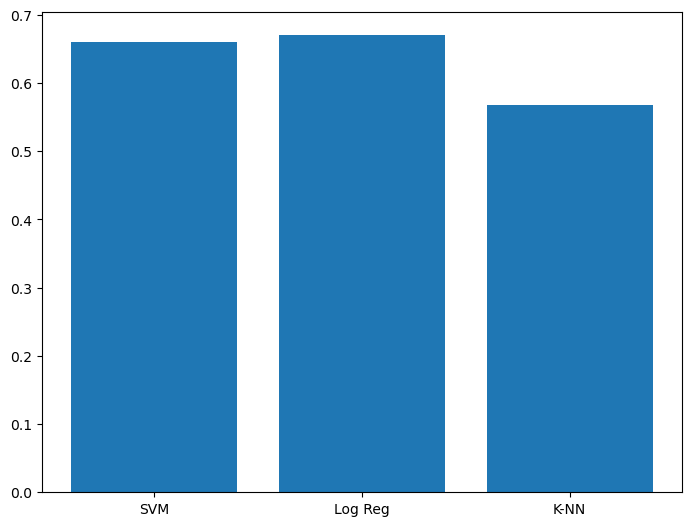

In [11]:
# Create a column chart with the top results of the MCC metric for the best performing models for each type
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
mcclead = [0.6605, 0.6703, 0.5683]
models = ["SVM","Log Reg","K-NN"]
ax.bar(models,mcclead)
plt.show()

### Best Performing Models' Processing Times:
Processing times are used to understand the adaptability and overall usability of the code. 

Text(0.5, 1.0, 'Processing Time for Best Model of Each Type')

Text(0.5, 0, 'model')

Text(0, 0.5, 'processing time')

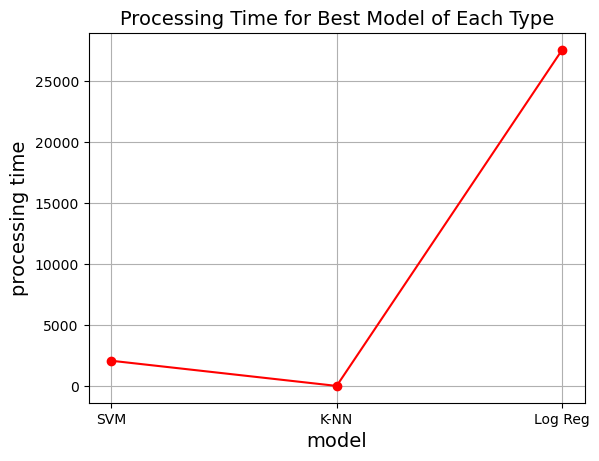

In [12]:
# Variables to create a plot with the processing times of the best performing models of each type
times = {'model': ["SVM", "K-NN","Log Reg"],
        'Processing Time (s)': [2095, 29, 27584]
       }

df = pd.DataFrame(times)
  
plt.plot(df['model'], df['Processing Time (s)'], color='red', marker='o')
plt.title('Processing Time for Best Model of Each Type', fontsize=14)
plt.xlabel('model', fontsize=14)
plt.ylabel('processing time', fontsize=14)
plt.grid(True)
plt.show()
